# Kagle Workflow

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [7]:
def process_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    columns = ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']
    for col in columns:
        df = create_dummies(df, col)
    return df

In [8]:
train = process_df(train)
holdout = process_df(holdout)

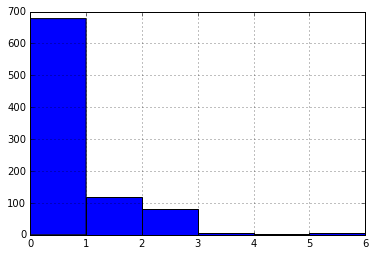

In [9]:
train.Parch.hist(bins = 6)
plt.show()

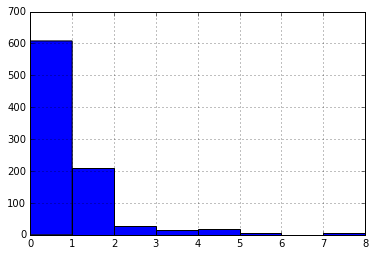

In [10]:
train.SibSp.hist(bins = 8)
plt.show()

In [11]:
sibsp_survived = pd.pivot_table(train[['SibSp', 'Survived']], index = 'SibSp', values = 'Survived' ,aggfunc = {np.sum, len})
sibsp_survived['perc_survived'] = sibsp_survived['sum']/sibsp_survived['len']

sibsp_survived

,len,sum,perc_survived
SibSp,,,
0,608,210,0.345395
1,209,112,0.535885
2,28,13,0.464286
3,16,4,0.250000
4,18,3,0.166667
5,5,0,0.000000
8,7,0,0.000000


In [12]:
Parch_survived = pd.pivot_table(train[['Parch', 'Survived']], index = 'Parch', values = 'Survived' ,aggfunc = {np.sum, len})
Parch_survived['perc_survived'] = Parch_survived['sum']/Parch_survived['len']

Parch_survived

,len,sum,perc_survived
Parch,,,
0,678,233,0.343658
1,118,65,0.550847
2,80,40,0.500000
3,5,3,0.600000
4,4,0,0.000000
5,5,1,0.200000
6,1,0,0.000000


It seems that people with a simbling or more had mora chance to not survive.

In [13]:
def isalone(df):
    alone = df[['Parch', 'SibSp']].sum(axis = 1) == 0
    df['isalone'] = alone*1
    return df

train = isalone(train)
holdout = isalone(holdout)

In [19]:
all_X = train.select_dtypes([np.number]).dropna(axis = 1).drop(['PassengerId','Survived'], axis = 1)
all_y = train['Survived']

# Features Selection

In [24]:
rf = RandomForestClassifier(random_state = 1)
selector = RFECV(rf, cv = 10)
selector.fit(all_X, all_y)
best_columns = list(all_X.columns[selector.support_])

best_columns

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Age_categories_Missing',
 'Age_categories_Infant',
 'Age_categories_Young Adult',
 'Fare_categories_12-50',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Cabin_type_D',
 'Cabin_type_E',
 'Cabin_type_Unknown',
 'Sex_female',
 'Sex_male',
 'isalone']

In [45]:
def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    models = [
        {
            'name': 'LogisticRegression',
            'estimator': LogisticRegression(),
            'hyperparameters':
            {
                "solver": ["newton-cg", "lbfgs", "liblinear"]
            }
        },
        {
            'name': 'KNeighborsClassifier',
            'estimator': KNeighborsClassifier(),
            'hyperparameters':
            {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
        },
        {
            'name': 'RandomForestClassifier',
            'estimator': RandomForestClassifier(),
            'hyperparameters':{
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
            }
        }]
    best_parameters = dict()
    best_estimator = dict()
    best_score = dict()
    
    for model in models:
        grid = GridSearchCV(model['estimator'],
                            param_grid = model['hyperparameters'],
                            cv = 10)
        grid.fit(all_X, all_y)
        best_estimator[model['name']] = grid.best_estimator_
        best_parameters[model['name']] = grid.best_params_
        best_score[model['name']] = grid.best_score_
    
    return best_estimator, best_parameters, best_score

In [47]:
best_estimator, best_parameters, best_score = select_model(train, best_columns)

In [48]:
best_score

{'KNeighborsClassifier': 0.7755331088664422,
 'LogisticRegression': 0.8204264870931538,
 'RandomForestClassifier': 0.8451178451178452}

In [97]:
def save_submission_file(models, cols, filename = 'submission.csv'):
    solutions = list()
    for key in models.keys():
        solutions.append(models[key].predict(holdout[cols]))
    
    prediction = np.round(sum(solutions)/len(models))
    submission = pd.DataFrame({'PassengerID': holdout.PassengerId, 'Survived': prediction}).astype({'Survived': int})
    submission.to_csv(filename, index = False)
    
    return submission

save_submission_file({1: best_estimator['RandomForestClassifier']}, best_columns)

,PassengerID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
